# Draw an isochrone map with OSMnx

# 1. Original example

Author: [Geoff Boeing](https://geoffboeing.com/)

How far can you travel on foot in 15 minutes?

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.settings.log_console=True
ox.settings.use_cache=True
ox.__version__

'1.9.1'

Can also use `travel_time` of the edges instead of calculating ``travel_speed`` as shown below.  
Might have to multiply ``travel_time`` by 60 to get travel_speed in km/h in the plotting functions.

In [2]:
# configure the place, network type, trip times, and travel speed
place = 'Berkeley, CA, USA'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

## Download and prep the street network

In [3]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

In [4]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

In [5]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

## Plots nodes you can reach on foot within each time

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [6]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

C:\Users\torha\AppData\Local\Temp\ipykernel_21496\2843268174.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)


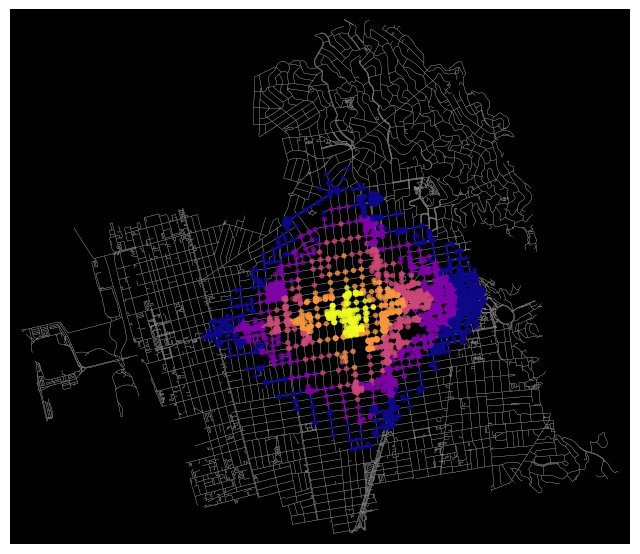

In [7]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

## Plot the time-distances as isochrones

How far can you walk in 5, 10, 15, 20, and 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

In [8]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

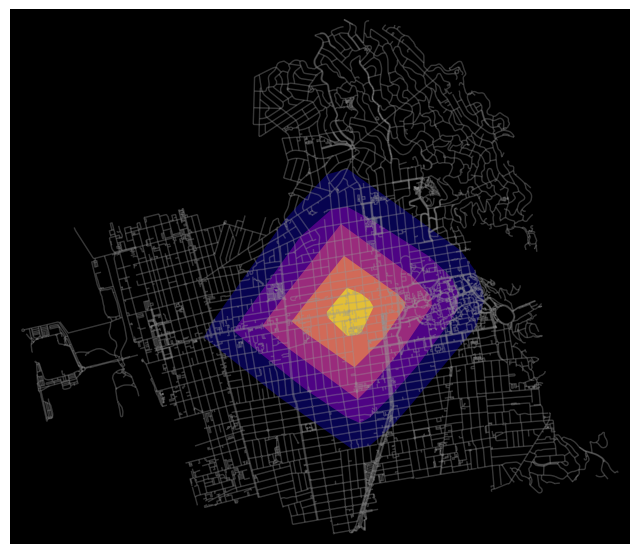

In [9]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

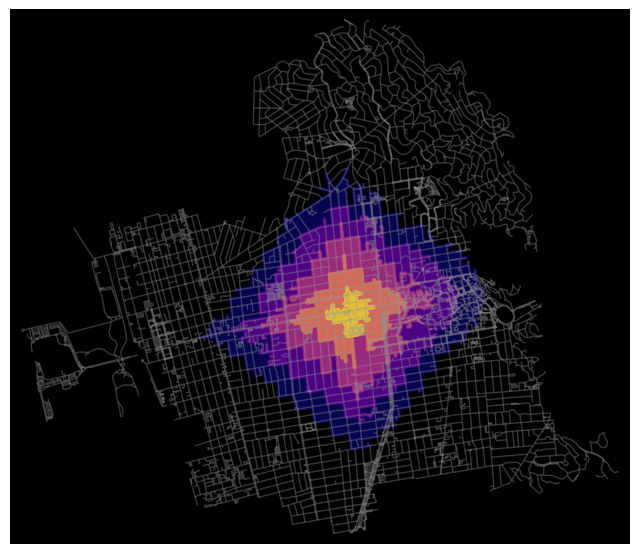

In [10]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Visualizing with leaflet on map

In [11]:
crs_proj = ox.graph_to_gdfs(G, nodes=False).crs
data = {'geometry': isochrone_polys, 'time': sorted(trip_times, reverse=True)}
isochrones = gpd.GeoDataFrame(data, crs=crs_proj)

# interactive leaflet map based on GeoDataFrame
isochrones.explore(column='time', cmap='plasma', edge_color='#999999', node_color='none', tiles="OpenStreetMap")
# isochrones.explore(column='time',cmap='Reds', tiles="CartoDB dark_matter") # dark version


# 2 Modified example - using travel_time from road network

In [12]:
# download the street network
# gruner_graph = ox.graph_from_place("Grünerløkka, Oslo, Norway", network_type="drive_service") # does not have edge speed

gruner_filepath = "GrunerGraphTravelTime.graphml" # GraphML format (with speed and travel time)
gruner_graph = ox.load_graphml(gruner_filepath) # originally in WGS84 (EPSG:4326)

gruner_graph = ox.projection.project_graph(gruner_graph, to_crs='EPSG:32633') # project to UTM zone 33N
print(f"Type of gruner_graph: {type(gruner_graph)}")
print(f"CRS of gruner_graph:  {gruner_graph.graph['crs']}")

Type of gruner_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of gruner_graph:  EPSG:32633


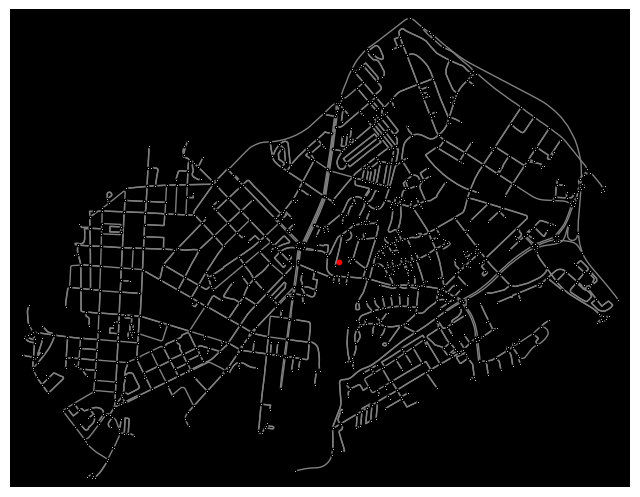

In [13]:
# Define how many trip times to visualize
trip_times = [1.5, 2.5, 4] # in minutes

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(gruner_graph, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.nearest_nodes(gruner_graph, x[0], y[0])
gruner_graph = ox.project_graph(gruner_graph, to_crs='EPSG:32633')

# plot graph with center node
fig, ax = ox.plot_graph(gruner_graph, node_color='w', node_edgecolor='k', node_size=3, node_zorder=3, edge_color='gray', bgcolor='k', show=False, close=False)
ax.scatter(x, y, c='r', s=10)
plt.show()

C:\Users\torha\AppData\Local\Temp\ipykernel_21496\1494963981.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)# color the nodes according to isochrone then plot the street network


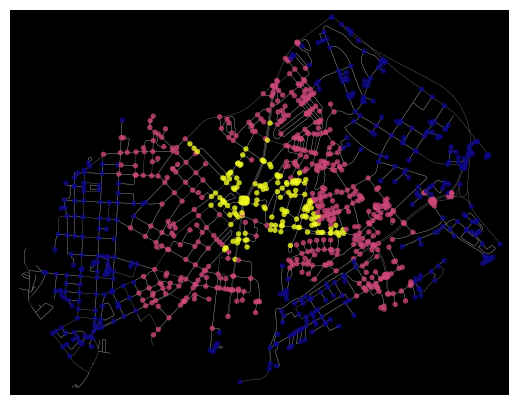

In [14]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)# color the nodes according to isochrone then plot the street network

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(gruner_graph, center_node, radius=trip_time*60, distance='travel_time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in gruner_graph.nodes()]
ns = [15 if node in node_colors else 0 for node in gruner_graph.nodes()]
fig, ax = ox.plot_graph(gruner_graph, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999', figsize=(7, 5))

In [15]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(gruner_graph, center_node, radius=trip_time*60, distance='travel_time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

# inspect isochrone polygons
print(f"Number of isochrone polygons: {len(isochrone_polys)}")
print(f"Type of isochrone polygons: {type(isochrone_polys)}")
print(f"Type of 1st isochrone polygon: {type(isochrone_polys[0])}")
print(f"isochrone polygons {isochrone_polys}")

Number of isochrone polygons: 3
Type of isochrone polygons: <class 'list'>
Type of 1st isochrone polygon: <class 'shapely.geometry.polygon.Polygon'>
isochrone polygons [<POLYGON ((263946.551 6649530.02, 262828.985 6649700.349, 262715.689 6649849...>, <POLYGON ((263378.785 6649839.813, 263283.438 6650114.424, 263050.676 665102...>, <POLYGON ((263914.519 6650335.074, 263845.69 6650398.938, 263617.913 6651093...>]


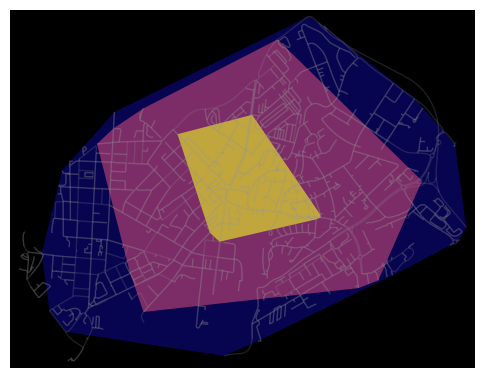

In [16]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(gruner_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k', figsize=(6, 5))
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

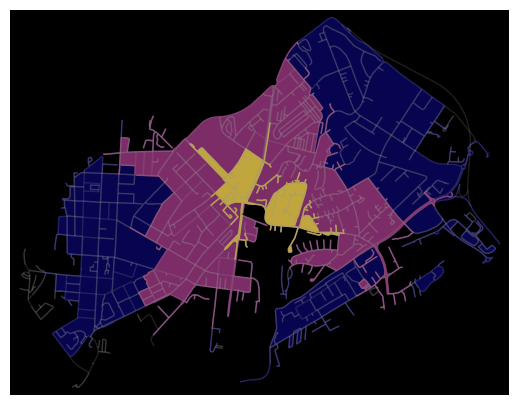

In [17]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time*60, distance='travel_time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(gruner_graph, edge_buff=5, node_buff=0, infill=True)
fig, ax = ox.plot_graph(gruner_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k', figsize=(7, 5))
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [18]:
crs_proj = ox.graph_to_gdfs(gruner_graph)[0].crs
data = {'trip_time': sorted(trip_times, reverse=True), 'geometry': isochrone_polys}
isochrones = gpd.GeoDataFrame(data,crs=crs_proj)

# interactive leaflet map based on GeoDataFrame
isochrones.explore(column='trip_time',cmap='Reds', tiles="OpenStreetMap") # light version
# isochrones.explore(column='trip_time',cmap='Reds', tiles="CartoDB dark_matter") # dark version

## 3. Isochrones from Multiple points, using travel_time

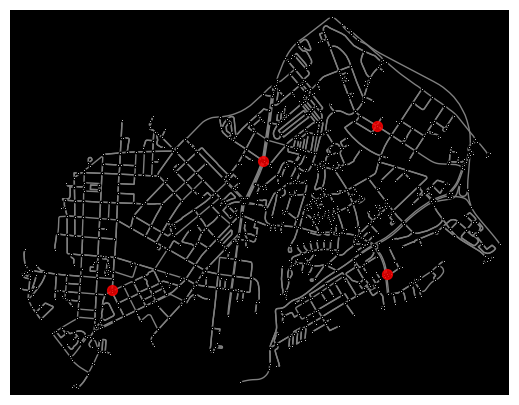

In [19]:
# Define how many trip times to visualize
trip_times = [0.3, 0.7, 1.2] # in minutes

# Assuming have already found optimal police car locations
optimal_police_locations = [3211547041, 1200648800, 786011978, 1387801966]
optimal_police_locations_ints = list(map(int, optimal_police_locations))

# Workaround to import CSV with "mulitple columns using geometry column name 'geometry'"
df = gpd.read_file("gruner_optimal_car_locations_gdf.csv", ignore_geometry=True)
# Create geometry objects from WKT strings
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
# Convert to GDF
gdf = gpd.GeoDataFrame(df)

# optimal_police_car_locations_gdf = gpd.read_file("gruner_optimal_car_locations_gdf.csv")
optimal_police_car_locations_gdf = gdf
optimal_police_car_locations_gdf.crs = "EPSG:32633"

# plot graph with the optimal police car locations from the GeoDataFrame
fig, ax = ox.plot_graph(gruner_graph, node_color='w', node_edgecolor='k', node_size=3, node_zorder=3, edge_color='gray', bgcolor='k', show=False, close=False, figsize=(7, 5))
optimal_police_car_locations_gdf.plot(ax=ax, color='r', markersize=50, alpha=0.8, zorder=3)
plt.show()

### 6.3.1 Plots nodes you can reach within each time

How far can you drive in 5, 10, 15, 20, and 25 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on trip time and travel speed.

C:\Users\torha\AppData\Local\Temp\ipykernel_21496\2982969653.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release.
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)# color the nodes according to isochrone then plot the street network


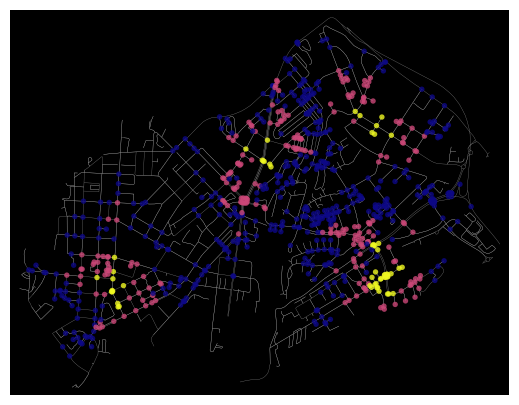

In [20]:
# # get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)# color the nodes according to isochrone then plot the street network

optimal_locations = optimal_police_locations_ints

# Initialize node_colors with 'none' for all nodes
node_colors = {node: 'none' for node in gruner_graph.nodes()}

for center_node in optimal_locations:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(gruner_graph, center_node, radius=trip_time*60, distance='travel_time')
        for node in subgraph.nodes():
            # Only update the color if it is 'none' or if the new color is closer (i.e., a "stronger" isochrone)
            if node_colors[node] == 'none' or iso_colors.index(node_colors[node]) < iso_colors.index(color):
                node_colors[node] = color

# Prepare node colors and sizes for plotting
nc = [node_colors[node] for node in gruner_graph.nodes()]
ns = [15 if node_colors[node] != 'none' else 0 for node in gruner_graph.nodes()]

# Plotting the graph with the updated colors and sizes AND legend
fig, ax = ox.plot_graph(gruner_graph, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999', figsize=(7, 5), show=False, close=False)

### 6.3.2 Plot the time-distances as isochrones

How far can you drive in 5, 10, 15, 20, and 25 minutes from the origin nodes? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

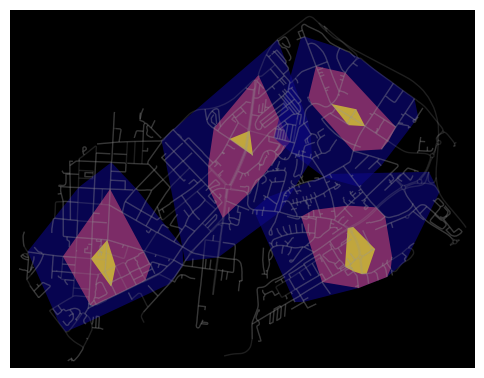

In [21]:
# Initialize a list to store isochrone polygons for all trip times and all center nodes
all_isochrone_polys = []

for center_node in optimal_locations:
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(gruner_graph, center_node, radius=trip_time*60, distance='travel_time')
        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
        isochrone_polys.append(bounding_poly)
    all_isochrone_polys.append(isochrone_polys)

# Plot the network
fig, ax = ox.plot_graph(gruner_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k', figsize=(6, 5))

# Plot each set of isochrone polygons with the corresponding colors
for isochrone_polys in all_isochrone_polys:
    for polygon, fc in zip(isochrone_polys, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

### 6.3.3 Plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

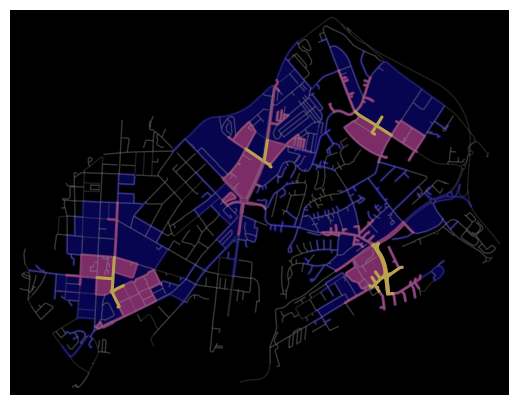

In [22]:
def make_iso_polys(G, center_nodes, edge_buff=25, node_buff=50, infill=False):
    all_isochrone_polys = []
    for center_node in center_nodes:
        isochrone_polys = []
        for trip_time in sorted(trip_times, reverse=True):
            subgraph = nx.ego_graph(G, center_node, radius=trip_time*60, distance='travel_time')

            node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
            nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                f = nodes_gdf.loc[n_fr].geometry
                t = nodes_gdf.loc[n_to].geometry
                edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry', LineString([f, t]))
                edge_lines.append(edge_lookup)

            n = nodes_gdf.buffer(node_buff).geometry
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).unary_union
            
            if infill:
                new_iso = Polygon(new_iso.exterior)
            isochrone_polys.append(new_iso)
        all_isochrone_polys.append(isochrone_polys)
    return all_isochrone_polys

# Adjust edge_buff and node_buff as needed
isochrone_polys = make_iso_polys(gruner_graph, optimal_locations, edge_buff=10, node_buff=0, infill=True)

fig, ax = ox.plot_graph(gruner_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                        node_size=0, bgcolor='k', figsize=(7, 5))

for isochrone_set in isochrone_polys:
    for polygon, fc in zip(isochrone_set, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()

### Plot isochrones on interactive map

In [23]:
# Flatten the isochrone_polys list and create a matching trip_time list
flat_isochrone_polys = [poly for sublist in isochrone_polys for poly in sublist]
# Repeat each trip time for as many center nodes you have
repeated_trip_times = sorted(trip_times * len(optimal_locations), reverse=True)

crs_proj = ox.graph_to_gdfs(gruner_graph, nodes=False).crs  # Adjusted to explicitly state nodes=False
data = {'trip_time': repeated_trip_times, 'geometry': flat_isochrone_polys}
isochrones = gpd.GeoDataFrame(data, crs=crs_proj)

# Interactive leaflet map based on GeoDataFrame
# isochrones.explore(column='trip_time', cmap='Reds', tiles="OpenStreetMap", style_kwds={'fillOpacity': 0.5, 'lineOpacity': 0.5}) # light version
# remove gridlines
isochrones.explore(column='trip_time',cmap='Reds', tiles="CartoDB dark_matter") # dark version